# Twitter Sentiment Analysis for ChatGPT

## Table of Contents
* [0. Notes](#0._notes)
* [1. Reading Data and Exploratory Data Analysis](#reading_data)
    * [1.1 Importing Libraries](#1.1_importing_libraries)
    * [1.2 Importing Data and First Impressions](#1.2_importing_data)
    * [1.3 Generating new time variables from a datetime column in a Pandas DataFrame](#generating_new_time)
    * [1.4 Exploring Data](#function_for_plotting)
* [2. Data Preprocessing for Sentiment Analysis](#data_preprocessing)
* [3. Model](#model)
* [4. Sentiment Analysis](#sentiment_analysis)
    * [4.1 Removing Stopwords](#removing_stopwords)
    * [4.2 Labeling Tweets](#labeling_tweets)
    * [4.3 Label Frequencies](#label_frequencies)
    * [4.4 Creating New Dataframes based Label and Most Frequent Words](#4.3_creating_new)
        * [i. Top Positive Words](#i._top_positive)
        * [ii. Top Neutral Words](#ii._top_neutral)
        * [iii. Top Negative Words](#iii._top_negative)
    * [4.5 Labeled Tweets per Day](#4.4_labeled_tweets)
    * [4.6 Tweet Engagements by Sentiment Label](#tweet_engagements)
    * [4.7 Average Tweet Engagemets by Sentiment Label](#4.5_average_tweet)
    * [4.8 Average Tweet Length by Sentiment Label](#average_tweet)
    * [4.9 Relationship between RetweetCount and LikeCount metrics](#4.7_relationship_between)
* [5. WordCloud](#wordcloud)
    * [5.1 WordCloud of Whole Dataframe](#5.1_wordcloud_of)
    * [5.2 Positive Tweets' WordCloud](#5.2_positive_tweets)
    * [5.3 Neutral Tweets' WordCloud](#5.3_neutral_tweets)
    * [5.4 Negative Tweets' WordCloud](#5.4_negative_tweets)

## 0. Notes <a class="anchor" id="0._notes"></a>
  - This project is based on the tweets about ChatGPT after the announcement about release of GPT-4.
  - The aim of the project is to determine the thoughts and tendencies of twitter users about ChatGPT, one of today's popular applications.

## 1. Readind Data and Exploratory Data Analysis <a class="anchor" id="readind_data"></a>

- The data consists of 100,000 tweets (include duplicates) in English containing the word "chatgpt" between 2023-03-18 and 2023-03-21.
- Variables;
  - ID: unique tweet id
  - Date: date the tweet was sent
  - Username: username of the person who tweeted (ranfom IDs for privacy)
  - Tweet: content of the tweet (tags and links deleted)
  - ReplyCount: number of replies to tweets
  - RetweetCount: number of retweets to tweets
  - LikeCount: number of likes to tweets
  - QuotesCount: number of quotes to tweets


### 1.1 Importing Libraries <a class="anchor" id="1.1_importing_libraries"></a>


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from wordcloud import WordCloud, ImageColorGenerator
from transformers import AutoModelForSequenceClassification, AutoTokenizer, pipeline

import re
import emoji
from tqdm.notebook import tqdm
import warnings

# Download NLTK data
nltk.download('punkt')
nltk.download('stopwords')

# Set display options
pd.set_option('display.float_format', '{:.4f}'.format)

# Ignore warnings
warnings.filterwarnings('ignore')


/home/khairi/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.
[nltk_data] Error loading punkt: <urlopen error [Errno -2] Name or
[nltk_data]     service not known>
[nltk_data] Error loading stopwords: <urlopen error [Errno -2] Name or
[nltk_data]     service not known>


In [7]:
# Constants
DATASET_PATH        = "/home/khairi/DataSets/Twitter_Sentiment_Analysis_for_ChatGPT/tweets.csv"
DATASET_PROC_PATH   = "/home/khairi/DataSets/Twitter_Sentiment_Analysis_for_ChatGPT/tweets-processed.csv"

### 1.2 Importing Data and First Impressions <a class="anchor" id="1.2_importing_data"></a>


In [8]:
df = pd.read_csv(DATASET_PATH)
print("The number of unique tweets:", df.shape[0])

The number of unique tweets: 98759


In [6]:
# show a sample of the dataset
df.head()

,ID,Date,Username,Tweet,ReplyCount,RetweetCount,LikeCount,QuoteCount
0,1638329623946878976,2023-03-21 23:59:55+00:00,lqgds36373,ChatGPT is another woke machine.,4,4,32,0
1,1638329621581275136,2023-03-21 23:59:55+00:00,yxwec12342,"of the Atlantic, or only near the Atla #推特账号 m...",0,0,0,0
2,1638329600471171074,2023-03-21 23:59:50+00:00,cwsea23772,This thread is saved to your Notion database....,0,0,0,0
3,1638329587133194240,2023-03-21 23:59:46+00:00,jerje51666,Prompt AI – ChatGPT #0018,1,0,0,0
4,1638329567759802368,2023-03-21 23:59:42+00:00,wwxly15746,Just had some interesting conversations with G...,1,0,0,0


In [19]:
# general info about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98759 entries, 0 to 98758
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype              
---  ------        --------------  -----              
 0   ID            98759 non-null  int64              
 1   Date          98759 non-null  datetime64[ns, UTC]
 2   Username      98759 non-null  object             
 3   Tweet         98759 non-null  object             
 4   ReplyCount    98759 non-null  int64              
 5   RetweetCount  98759 non-null  int64              
 6   LikeCount     98759 non-null  int64              
 7   QuoteCount    98759 non-null  int64              
 8   OnlyDate      98759 non-null  datetime64[ns]     
 9   OnlyHour      98759 non-null  int64              
 10  OnlyMin       98759 non-null  int64              
dtypes: datetime64[ns, UTC](1), datetime64[ns](1), int64(7), object(2)
memory usage: 8.3+ MB


In [22]:
# general info about the dataset
df.describe()

,ID,ReplyCount,RetweetCount,LikeCount,QuoteCount,OnlyHour,OnlyMin
count,98759.0000,98759.0000,98759.0000,98759.0000,98759.0000,98759.0000,98759.0000
mean,1637481406058415616.0000,1.3467,1.3948,9.7873,0.2590,12.8277,28.9870
std,563281176533013.5000,32.8560,35.9637,245.5766,19.7567,6.4592,17.5690
min,1636521747540242432.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
25%,1636926715759888384.0000,0.0000,0.0000,0.0000,0.0000,8.0000,14.0000
50%,1637527761219645440.0000,0.0000,0.0000,0.0000,0.0000,14.0000,29.0000
75%,1637975215293546496.0000,1.0000,0.0000,2.0000,0.0000,18.0000,44.0000
max,1638329623946878976.0000,4984.0000,4076.0000,36112.0000,5415.0000,23.0000,59.0000


In [8]:
df.isnull().sum()

ID              0
Date            0
Username        0
Tweet           0
ReplyCount      0
RetweetCount    0
LikeCount       0
QuoteCount      0
dtype: int64

no, null values

### 1.3 Generating new time variables from a datetime column in a Pandas DataFrame <a class="anchor" id="generating_new_time"></a>
Generating new time variables allows us to explore and analyze time-based data, such as tweets, and identify temporal patterns and trends that may be relevant for analysis or prediction.

In [25]:
df['Date']     = pd.to_datetime(df['Date'])
df['OnlyDate'] = df['Date'].dt.date
df['OnlyDate'] = pd.to_datetime(df['OnlyDate'])
df['OnlyHour'] = df['Date'].dt.hour
df['OnlyMin']  = df['Date'].dt.minute

In [17]:
df.head()

,ID,Date,Username,Tweet,ReplyCount,RetweetCount,LikeCount,QuoteCount,OnlyDate,OnlyHour,OnlyMin
0,1638329623946878976,2023-03-21 23:59:55+00:00,lqgds36373,ChatGPT is another woke machine.,4,4,32,0,2023-03-21,23,59
1,1638329621581275136,2023-03-21 23:59:55+00:00,yxwec12342,"of the Atlantic, or only near the Atla #推特账号 m...",0,0,0,0,2023-03-21,23,59
2,1638329600471171074,2023-03-21 23:59:50+00:00,cwsea23772,This thread is saved to your Notion database....,0,0,0,0,2023-03-21,23,59
3,1638329587133194240,2023-03-21 23:59:46+00:00,jerje51666,Prompt AI – ChatGPT #0018,1,0,0,0,2023-03-21,23,59
4,1638329567759802368,2023-03-21 23:59:42+00:00,wwxly15746,Just had some interesting conversations with G...,1,0,0,0,2023-03-21,23,59


In [11]:
# the data was scraped between the 18 and the 21st of 03/2023
# we'll get the count of each day's tweets
df['OnlyDate'].value_counts()

2023-03-21    25074
2023-03-17    22923
2023-03-20    20790
2023-03-19    15187
2023-03-18    14785
Name: OnlyDate, dtype: int64

In [12]:
# avrage tweet per day
avg_tweets_per_day = df.groupby(df['OnlyDate'])['ID'].count().mean()
print("Average tweets per day:", avg_tweets_per_day)

Average tweets per day: 19751.8


### 1.4 Exploring Data <a class="anchor" id="function_for_plotting"></a>
This function takes in a Pandas DataFrame and the name of a time column, and then plots a line graph of the time counts using the specified column.

In [27]:
def plot_time_variable(col, ylim_lower = 10000, ylim_upper = 30000):

    if df[col].dtype == "int64":
        time_variable_counts = df[col].value_counts().sort_index()

    else:
        time_variable_counts = df[col].value_counts().resample('D').sum()

    # set the size of the figure
    plt.figure(figsize=(12, 8))

    # plot the counts using a line graph
    time_variable_counts.plot(kind='line', marker='o', markersize=8)

    plt.ylim(ylim_lower, ylim_upper)

    # add graph labels and titles
    plt.title(f"{col} tweet Counts", fontsize=16)
    plt.xlabel(f"{col}", fontsize=14)
    plt.ylabel("Count", fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--')

    # display the graph
    plt.show()


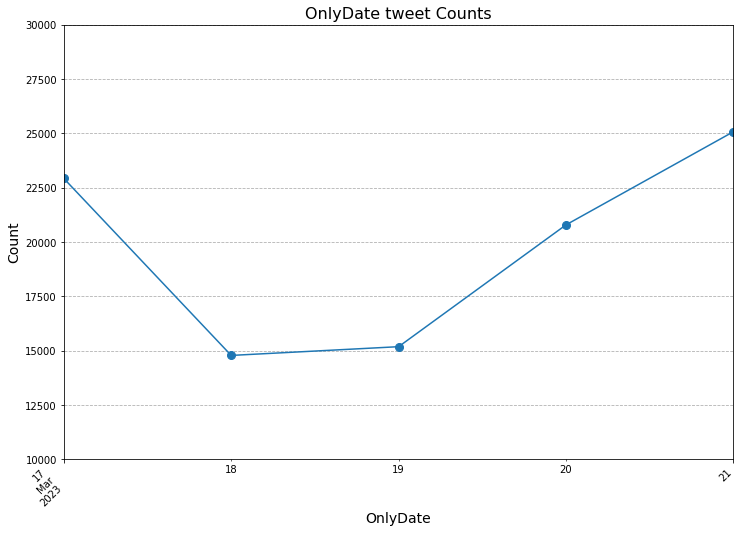

In [14]:
# destribution of tweets per day
plot_time_variable('OnlyDate')

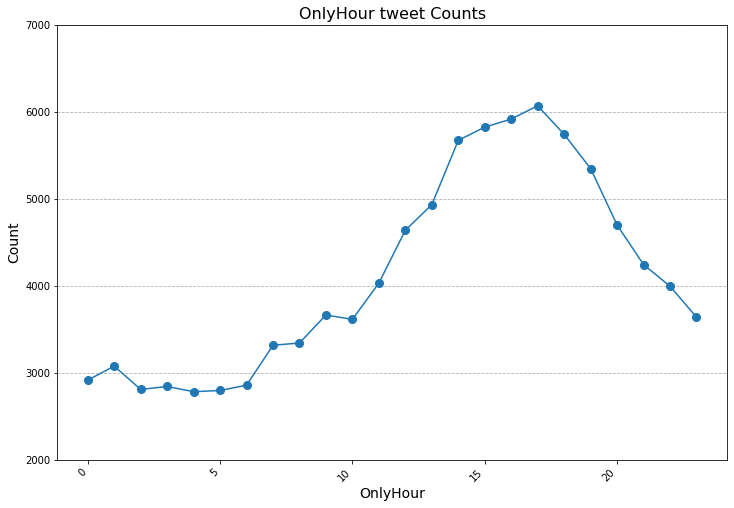

In [15]:
# destribution of tweets per hour
plot_time_variable('OnlyHour', 2000, 7000)

In [34]:
# correlation between engagement metrics
corr_matrix = df[['ID', 'ReplyCount', 'RetweetCount', 'LikeCount', 'QuoteCount']].corr()
corr_matrix

,ID,ReplyCount,RetweetCount,LikeCount,QuoteCount
ID,1.0000,0.0055,-0.0005,0.0061,-0.0003
ReplyCount,0.0055,1.0000,0.4940,0.3302,0.1095
RetweetCount,-0.0005,0.4940,1.0000,0.8040,0.2302
LikeCount,0.0061,0.3302,0.8040,1.0000,0.3085
QuoteCount,-0.0003,0.1095,0.2302,0.3085,1.0000


we can see that there is a strong correlation between the likeCount and RetweetCount. We'll explore the relationships of the metrics in a later chapter.

In [31]:
def get_top_words(df, column_name, top_n=20):
    # get the list of tweets from the specified column
    tweets = df[column_name].astype(str).tolist()

    # tokenize all the words from the tweets
    words = []
    for tweet in tweets:
        words += word_tokenize(tweet.lower())

    # calculate the frequency distribution of words
    freq_dist = FreqDist(words)

    # return the top n most common words
    return freq_dist.most_common(top_n)

In [18]:
# top words in the dataset
get_top_words(df, "Tweet", 20)

[('#', 105632),
 ('chatgpt', 87177),
 ('.', 80118),
 (',', 64766),
 ('the', 64059),
 ('to', 61979),
 ('a', 42551),
 ('and', 42077),
 ('it', 36961),
 ('i', 36778),
 ('is', 34170),
 ('of', 32172),
 ('for', 24737),
 ('in', 22758),
 ('you', 22560),
 ('ai', 21761),
 (':', 19586),
 ('?', 19311),
 ('that', 18500),
 ('with', 17939)]

## 2. Data Preprocessing for Sentiment Analysis <a class="anchor" id="data_preprocessing"></a>

In [19]:
# helper functions to clean tweets for processing

def preprocess_word(word):
    # Remove punctuation
    word = word.strip('\'"?!,.():;')

    # Convert more than 2 letter repetitions to 2 letter
    # funnnnny --> funny
    word = re.sub(r'(.)\1+', r'\1\1', word)
    # Remove - & '
    word = re.sub(r'(-|\')', '', word)
    return word

def handle_emojis(tweet):
    # Smile -- :), : ), :-), (:, ( :, (-:, :')
    tweet = re.sub(r'(:\s?\)|:-\)|\(\s?:|\(-:|:\'\))', ' EMO_POS ', tweet)
    # Laugh -- :D, : D, :-D, xD, x-D, XD, X-D
    tweet = re.sub(r'(:\s?D|:-D|x-?D|X-?D)', ' EMO_POS ', tweet)
    # Love -- <3, :*
    tweet = re.sub(r'(<3|:\*)', ' EMO_POS ', tweet)
    # Wink -- ;-), ;), ;-D, ;D, (;,  (-;
    tweet = re.sub(r'(;-?\)|;-?D|\(-?;)|😉', ' EMO_POS ', tweet)
    # Sad -- :-(, : (, :(, ):, )-:
    tweet = re.sub(r'(:\s?\(|:-\(|\)\s?:|\)-:)', ' EMO_NEG ', tweet)
    # Cry -- :,(, :'(, :"(
    tweet = re.sub(r'(:,\(|:\'\(|:"\()', ' EMO_NEG ', tweet)
    return tweet


def remove_emoji(tweet):
    return emoji.replace_emoji(tweet, replace=" ")


def preprocess_tweet(tweet):
    processed_tweet = []
    # Convert to lower case
    tweet = tweet.lower()

    # Replaces URLs with the word URL
    tweet = re.sub(r'((www\.[\S]+)|(https?://[\S]+))', ' URL ', tweet)

    # Replace @handle with the word USER_MENTION
    tweet = re.sub(r'@[\S]+', '', tweet)

    # Replaces #hashtag with hashtag
    tweet = re.sub(r'#(\S+)', r' \1 ', tweet)
    # tweet = re.sub(r'#(\S+)', '', tweet)

    # Remove RT (retweet)
    tweet = re.sub(r'\brt\b', '', tweet)

    # Replace 2+ dots with space
    tweet = re.sub(r'\.{2,}', ' ', tweet)

    # Strip space, " and ' from tweet
    tweet = tweet.strip(' "\'')

    # Replace emojis with either EMO_POS or EMO_NEG
    tweet = handle_emojis(tweet)

    #remove emojis
    tweet = remove_emoji(tweet)

    # Replace multiple spaces with a single space
    tweet = re.sub(r'\s+', ' ', tweet)
    words = tweet.split()

    for word in words:
        word = preprocess_word(word)
        processed_tweet.append(word)

    return ' '.join(processed_tweet)

In [20]:
# testing the helper functions
index = 98456
print(df.loc[index].Tweet)
preprocess_tweet(df.loc[index].Tweet)

     I asked ChatGPT for other movies with androids with numbers indicating their level of humanity. I would doubt it was 1 of the 4 it suggested: 3 were from the 1980s. 3 of them had single featured androids. Escape from Galaxy 3 came closest, I think


'i asked chatgpt for other movies with androids with numbers indicating their level of humanity i would doubt it was 1 of the 4 it suggested 3 were from the 1980s 3 of them had single featured androids escape from galaxy 3 came closest i think'

In [21]:
# apply the helper functions on the dataset
df["processed_tweet"] = df["Tweet"].apply(preprocess_tweet)

In [22]:
df.head()

,ID,Date,Username,Tweet,ReplyCount,RetweetCount,LikeCount,QuoteCount,OnlyDate,OnlyHour,OnlyMin,processed_tweet
0,1638329623946878976,2023-03-21 23:59:55+00:00,lqgds36373,ChatGPT is another woke machine.,4,4,32,0,2023-03-21,23,59,chatgpt is another woke machine
1,1638329621581275136,2023-03-21 23:59:55+00:00,yxwec12342,"of the Atlantic, or only near the Atla #推特账号 m...",0,0,0,0,2023-03-21,23,59,of the atlantic or only near the atla 推特账号 mor...
2,1638329600471171074,2023-03-21 23:59:50+00:00,cwsea23772,This thread is saved to your Notion database....,0,0,0,0,2023-03-21,23,59,this thread is saved to your notion database t...
3,1638329587133194240,2023-03-21 23:59:46+00:00,jerje51666,Prompt AI – ChatGPT #0018,1,0,0,0,2023-03-21,23,59,prompt ai – chatgpt 0018
4,1638329567759802368,2023-03-21 23:59:42+00:00,wwxly15746,Just had some interesting conversations with G...,1,0,0,0,2023-03-21,23,59,just had some interesting conversations with g...


## 3. Model <a class="anchor" id="model"></a>

Trained model from huggingface :
  - https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment-latest

In [ ]:
# load model and tokenizer
model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest")
tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest")

# create pipeline
sa = pipeline("sentiment-analysis", tokenizer=tokenizer, model=model)

## 4. Sentiment Analysis <a class="anchor" id="sentiment_analysis"></a>


### 4.1 Removing Stopwords <a class="anchor" id="removing_stopwords"></a>

In [ ]:
# Extracting english stopwords from processed tweets
sw = stopwords.words('english')
df['processed_tweet_without_stopwords'] = df['processed_tweet'].apply(lambda x: " ".join(x for x in str(x).split() if x not in sw))
df.head()

### 4.2 Labeling Tweets <a class="anchor" id="labeling_tweets"></a>

In [24]:
def get_sentiment_analysis(tweet):
    # encode the tweet using the tokenizer
    encoded_tweet = tokenizer(tweet, padding=True, truncation=True, return_tensors="pt")

    # make the prediction with the model
    with torch.no_grad():
        predictions = model(**encoded_tweet)

    # get the predicted label and score
    label = sa.tokenizer.decode(predictions.label[0])
    score = float(predictions[0][int(label)])

    return (label, score)


df["sentiment_label"] = "-"
df["sentiment_score"] = -1

df_part_1 = df[:25000]
df_part_2 = df[25000:50000]
df_part_3 = df[50000:75000]
df_part_4 = df[75000:]

df_part_1[["sentiment_label", "sentiment_score"]] = df_part_1["processed_tweet"].progress_apply(get_sentiment_analysis) #1 hours 6 minutes
df_part_2[["sentiment_label", "sentiment_score"]] = df_part_2["processed_tweet"].progress_apply(get_sentiment_analysis) #1 hours 3 minutes
df_part_3[["sentiment_label", "sentiment_score"]] = df_part_3["processed_tweet"].progress_apply(get_sentiment_analysis) #1 hours 3 minutes
df_part_4[["sentiment_label", "sentiment_score"]] = df_part_4["processed_tweet"].progress_apply(get_sentiment_analysis) # 59 minutes

df = pd.concat([df_part_1, df_part_2, df_part_3, df_part_4], axis=0)


since the labeling and scoring process took a long time (100k tweets), I used a labeled (using the same model) version of the data for sentiment analysis.


In [33]:
# load labled data
dfs = pd.read_csv(DATASET_PROC_PATH)
dfs['processed_tweet'] = dfs['processed_tweet'].str.replace('[^\w\s]', '')

dfs.head()

,ID,Date,Username,Tweet,ReplyCount,RetweetCount,LikeCount,QuoteCount,OnlyDate,OnlyHour,OnlyMin,processed_tweet,sentiment_label,sentiment_score
0,1638329623946878976,2023-03-21 23:59:55+00:00,lqgds36373,ChatGPT is another woke machine.,4,4,32,0,2023-03-21,23,59,chatgpt is another woke machine,negative,0.8628
1,1638329621581275136,2023-03-21 23:59:55+00:00,yxwec12342,"of the Atlantic, or only near the Atla #推特账号 m...",0,0,0,0,2023-03-21,23,59,of the atlantic or only near the atla more to ...,neutral,0.8373
2,1638329600471171074,2023-03-21 23:59:50+00:00,cwsea23772,This thread is saved to your Notion database....,0,0,0,0,2023-03-21,23,59,this thread is saved to your notion database t...,neutral,0.8854
3,1638329587133194240,2023-03-21 23:59:46+00:00,jerje51666,Prompt AI – ChatGPT #0018,1,0,0,0,2023-03-21,23,59,prompt ai chatgpt,neutral,0.8958
4,1638329567759802368,2023-03-21 23:59:42+00:00,wwxly15746,Just had some interesting conversations with G...,1,0,0,0,2023-03-21,23,59,just had some interesting conversations with g...,positive,0.9558


### 4.3 Label Frequencies <a class="anchor" id="label_frequencies"></a>


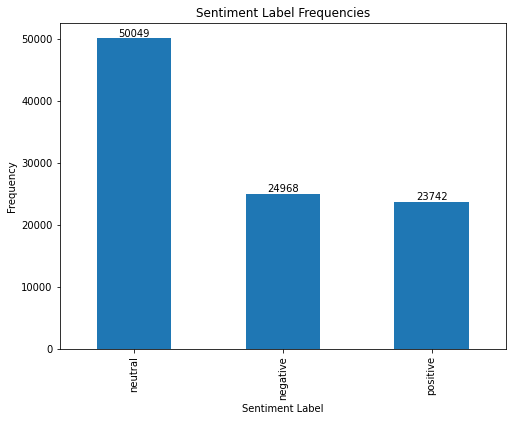

[50049 24968 23742]


In [36]:
# count the frequency of each sentiment label
sentiment_counts = dfs.sentiment_label.value_counts()

# create a column plot
fig, ax = plt.subplots(figsize=(8,6))
sentiment_counts.plot(kind='bar', ax=ax)

# set the plot title and axis labels
ax.set_title('Sentiment Label Frequencies')
ax.set_xlabel('Sentiment Label')
ax.set_ylabel('Frequency')

# add data labels to the top of each column
for i, freq in enumerate(sentiment_counts):
    ax.text(i, freq, str(freq), ha='center', va='bottom')

# display the plot
plt.show()

the Neutral tweets are almost as much as the positive and negative tweets.

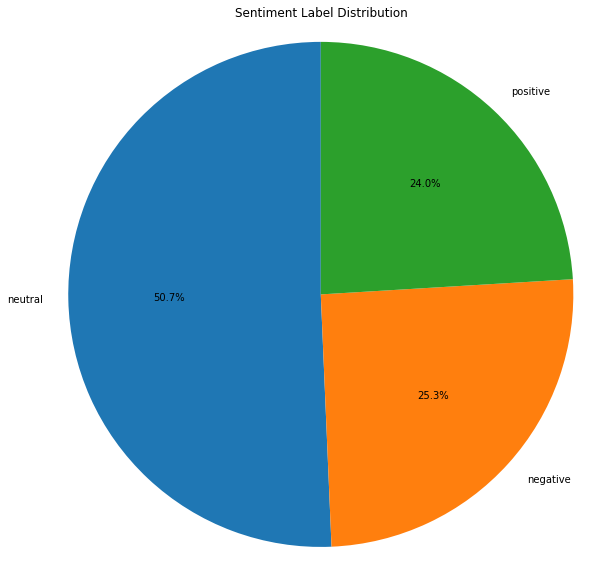

In [46]:
# Pie chart of the Distribution of sentiment labels
df_sentiment_counts = pd.DataFrame({'Sentiment Label': sentiment_counts.index, 'Counts': sentiment_counts.values})

plt.figure(figsize=(10, 10))
plt.pie(df_sentiment_counts['Counts'], labels=df_sentiment_counts['Sentiment Label'], autopct='%1.1f%%', startangle=90)
plt.title('Sentiment Label Distribution')
plt.axis('equal')
plt.show()

- 50.7% of the tweets are neutral
- 25.3% of the tweets are negative
- 24.0% of the tweets are positive

In [50]:
# engagement metrics of each sentiment
popularity_indexes = ["ReplyCount", "RetweetCount", "LikeCount", "QuoteCount"]
dfs.groupby("sentiment_label").sum()[popularity_indexes]

,ReplyCount,RetweetCount,LikeCount,QuoteCount
sentiment_label,,,,
negative,26512,25271,238703,3560
neutral,46470,50398,355091,9461
positive,60021,62084,372792,12553


In [28]:
dfs.groupby("sentiment_label").mean()[popularity_indexes]

,ReplyCount,RetweetCount,LikeCount,QuoteCount
sentiment_label,,,,
negative,1.0618,1.0121,9.5604,0.1426
neutral,0.9285,1.0070,7.0949,0.1890
positive,2.5281,2.6149,15.7018,0.5287


- Tweets with a positive sentiment label tend to have higher values for all the popularity indexes, including ReplyCount, RetweetCount, LikeCount, and QuoteCount, compared to tweets with negative or neutral sentiment labels. This suggests that tweets with a positive sentiment are more likely to be engaged with by other users on the platform.
- Tweets with a negative sentiment label have the lowest values for all popularity indexes, indicating that they are less likely to be engaged with compared to tweets with neutral or positive sentiment labels.
- Tweets with a neutral sentiment label have lower values for all popularity indexes compared to positive sentiment tweets, but higher values compared to negative sentiment tweets. This suggests that tweets with a neutral sentiment are moderately engaging, but not as much as positive sentiment tweets.

### 4.4 Creating New Dataframes based Label and Most Frequent Words <a class="anchor" id="4.3_creating_new"></a>


In [30]:
# create new data frames for each sentiment label
df_positive = dfs[dfs["sentiment_label"] == "positive"]
df_neutral = dfs[dfs["sentiment_label"] == "neutral"]
df_negative = dfs[dfs["sentiment_label"] == "negative"]

#### i. Top Positive Words <a class="anchor" id="i._top_positive"></a>


In [31]:
get_top_words(df_positive, "processed_tweet_without_stopwords", 20)

[('chatgpt', 14753),
 ('ai', 4456),
 ('gpt', 2602),
 ('chat', 2526),
 ('gpt4', 2148),
 ('like', 2049),
 ('use', 1952),
 ('new', 1674),
 ('using', 1536),
 ('good', 1491),
 ('im', 1393),
 ('get', 1392),
 ('amp', 1286),
 ('help', 1274),
 ('time', 1197),
 ('great', 1108),
 ('better', 1105),
 ('make', 1094),
 ('one', 1063),
 ('see', 959)]

#### ii. Top Neutral Words <a class="anchor" id="ii._top_neutral"></a>


In [32]:
get_top_words(df_neutral, "processed_tweet_without_stopwords", 20)

[('chatgpt', 33490),
 ('ai', 7105),
 ('chat', 6446),
 ('gpt', 5703),
 ('use', 3502),
 ('like', 3031),
 ('using', 2679),
 ('asked', 2199),
 ('new', 2156),
 ('ask', 2113),
 ('write', 2076),
 ('google', 1939),
 ('gpt4', 1764),
 ('get', 1708),
 ('make', 1708),
 ('would', 1563),
 ('amp', 1521),
 ('via', 1520),
 ('one', 1496),
 ('know', 1470)]

#### iii. Top Negative Words <a class="anchor" id="iii._top_negative"></a>


In [33]:
get_top_words(df_negative, "processed_tweet_without_stopwords", 20)

[('chatgpt', 18721),
 ('chat', 3537),
 ('ai', 3201),
 ('gpt', 3121),
 ('like', 2759),
 ('dont', 1736),
 ('people', 1628),
 ('use', 1570),
 ('im', 1529),
 ('cant', 1371),
 ('even', 1346),
 ('get', 1322),
 ('using', 1219),
 ('write', 1197),
 ('know', 1154),
 ('think', 1136),
 ('one', 1136),
 ('make', 1036),
 ('would', 1032),
 ('asked', 1002)]

### 4.5 Labeled Tweets per Day <a class="anchor" id="4.4_labeled_tweets"></a>


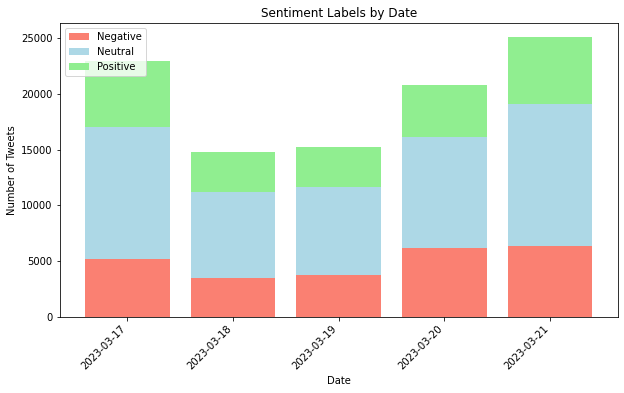

In [34]:
# pivot table to get the count of sentiment labels for each date
pivoted_df = pd.pivot_table(dfs[["OnlyDate", "sentiment_label"]], index='OnlyDate', columns='sentiment_label', aggfunc=len, fill_value=0)

# create bar chart
fig, ax = plt.subplots(figsize=(10,6))
ax.bar(pivoted_df.index.values, pivoted_df['negative'], color='salmon', label='Negative')
ax.bar(pivoted_df.index.values, pivoted_df['neutral'], bottom=pivoted_df['negative'], color='lightblue', label='Neutral')
ax.bar(pivoted_df.index.values, pivoted_df['positive'], bottom=pivoted_df['neutral']+pivoted_df['negative'], color='lightgreen', label='Positive')

# set axis labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Number of Tweets')
ax.set_title('Sentiment Labels by Date')

# rotate x-axis labels if needed
fig.autofmt_xdate(rotation=45)

# add legend
ax.legend(loc='upper left')

# show the plot
plt.show()

we can't conclude whether the positive/negative/neutral tweets kept on growing with time or not.

### 4.6 Tweet Engagements by Sentiment Label <a class="anchor" id="tweet_engagements"></a>

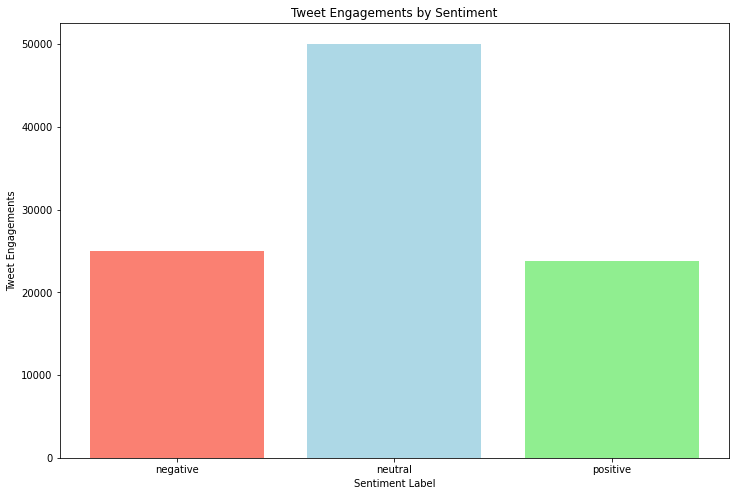

In [35]:
dfs["TotalEngagement"] = dfs["ReplyCount"] + dfs["RetweetCount"] + dfs["LikeCount"] + dfs["QuoteCount"]

# group by sentiment_label and calculate average tweet length
grouped = dfs.groupby('sentiment_label')['TotalEngagement'].count()

# create bar chart
fig, ax = plt.subplots(figsize=(12,8))
ax.bar(grouped.index, grouped.values, color=['salmon', 'lightblue', 'lightgreen'])

# set axis labels and title
ax.set_xlabel('Sentiment Label')
ax.set_ylabel('Tweet Engagements')
ax.set_title('Tweet Engagements by Sentiment')

# show the plot
plt.show()

### 4.7 Average Tweet Engagemets by Sentiment Label <a class="anchor" id="4.5_average_tweet"></a>


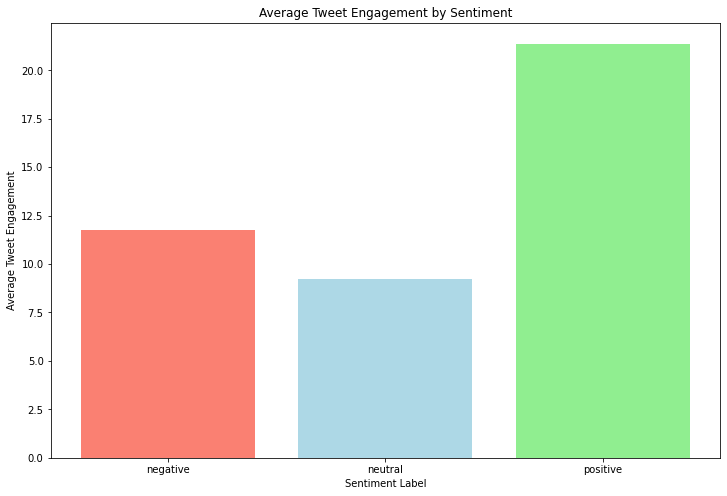

In [36]:
# Calculate the total engagement for each tweet

# group by sentiment_label and calculate average tweet length
grouped = dfs.groupby('sentiment_label')['TotalEngagement'].mean()

# create bar chart
fig, ax = plt.subplots(figsize=(12,8))
ax.bar(grouped.index, grouped.values, color=['salmon', 'lightblue', 'lightgreen'])

# set axis labels and title
ax.set_xlabel('Sentiment Label')
ax.set_ylabel('Average Tweet Engagement')
ax.set_title('Average Tweet Engagement by Sentiment')

# show the plot
plt.show()

Tweets with a neutral sentiment label generally receive the highest total count of engagements, in terms of likes, retweets, replies, and quotes. However, tweets with a positive sentiment label generally receive the highest average engagement, in terms of likes, retweets, replies, and quotes, compared to tweets with a negative or neutral sentiment label. Therefore, businesses and individuals looking to optimize their social media strategy and increase engagement on Twitter should consider both the sentiment label and the engagement metrics when creating and promoting their tweets.

### 4.8 Average Tweet Length by Sentiment Label <a class="anchor" id="average_tweet"></a>


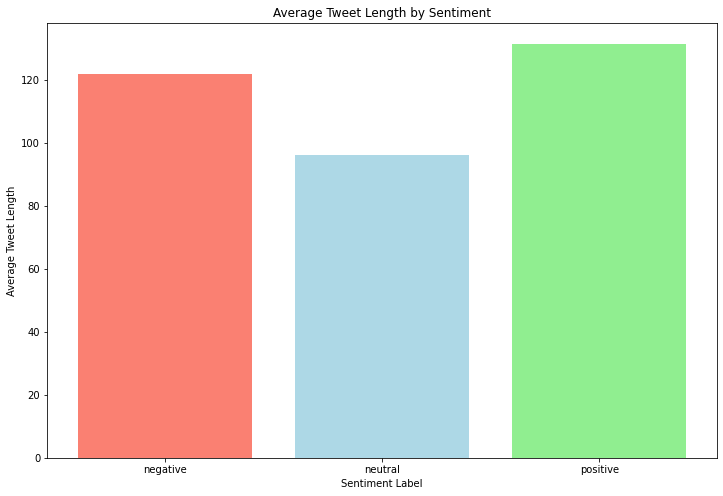

In [37]:
# calculate tweet lengths and add to dataframe
dfs['TweetLength'] = dfs['processed_tweet'].astype(str).apply(len)

# group by sentiment_label and calculate average tweet length
grouped = dfs.groupby('sentiment_label')['TweetLength'].mean()

# create bar chart
fig, ax = plt.subplots(figsize=(12,8))
ax.bar(grouped.index, grouped.values, color=['salmon', 'lightblue', 'lightgreen'])

# set axis labels and title
ax.set_xlabel('Sentiment Label')
ax.set_ylabel('Average Tweet Length')
ax.set_title('Average Tweet Length by Sentiment')

# show the plot
plt.show()

Positive and Negative tweets tend to be longuer than neutral tweets

### 4.9 Relationship between RetweetCount and LikeCount metrics <a class="anchor" id="4.7_relationship_between"></a>


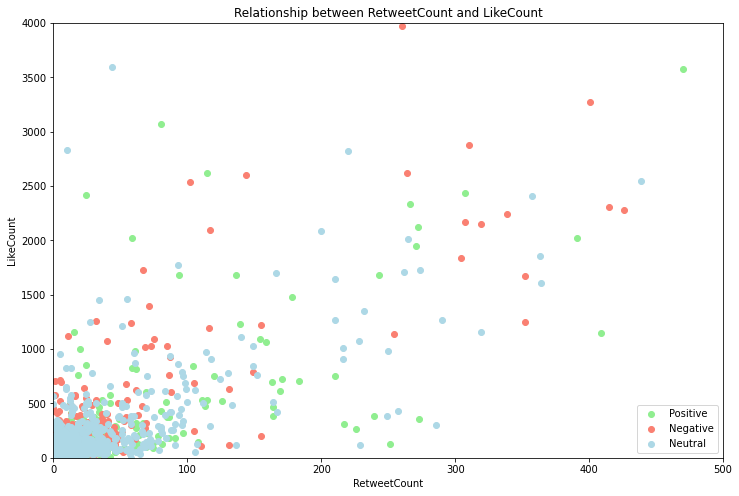

In [38]:
# Scatter plot for showing the relationship between RetweetCount and LikeCount variables, colored by sentiment_label
plt.figure(figsize=(12, 8))
plt.scatter(dfs[dfs['sentiment_label'] == 'positive']['RetweetCount'],
            dfs[dfs['sentiment_label'] == 'positive']['LikeCount'], c='lightgreen', label='Positive')

plt.scatter(dfs[dfs['sentiment_label'] == 'negative']['RetweetCount'],
            dfs[dfs['sentiment_label'] == 'negative']['LikeCount'], c='salmon', label='Negative')

plt.scatter(dfs[dfs['sentiment_label'] == 'neutral']['RetweetCount'],
            dfs[dfs['sentiment_label'] == 'neutral']['LikeCount'], c='lightblue', label='Neutral')

# Set the title, x and y axis labels
plt.title('Relationship between RetweetCount and LikeCount')
plt.xlabel('RetweetCount')
plt.ylabel('LikeCount')

# x and y axis limits
plt.xlim(0, 500)
plt.ylim(0, 4000)

# Add legend
plt.legend()

# Show the plot
plt.show()

we can deduce that the higher RetweetCount is, the higher the LikeCount will be

## 5. WordCloud <a class="anchor" id="wordcloud"></a>


In [39]:
# a function that takes a dataframe and the tweets column to represent in the WordCloud
def plot_wordcloud(df, col):

    # Concatenate all text data in the specified column into a single string
    text = " ".join(i for i in df[col])

    # Create a wordcloud object
    wc = WordCloud(background_color="white",
                   max_words=1000,
                   contour_width=3,
                   contour_color="firebrick",
                   width=800, height=400).generate(text)

    # Plot the wordcloud
    plt.figure(figsize=(12,8))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

### 5.1 WordCloud of Whole Dataframe <a class="anchor" id="5.1_wordcloud_of"></a>


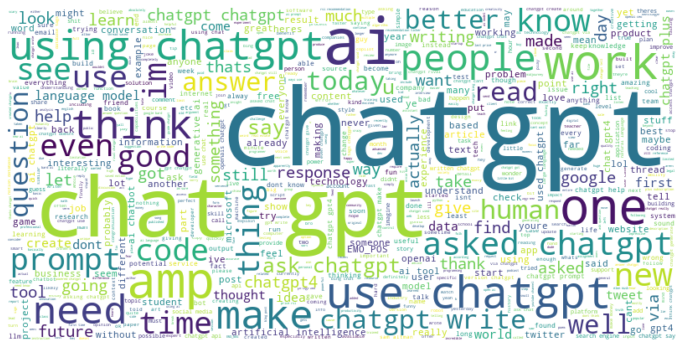

In [40]:
plot_wordcloud(dfs, "processed_tweet_without_stopwords")

### 5.2 Positive Tweets' WordCloud <a class="anchor" id="5.2_positive_tweets'"></a>


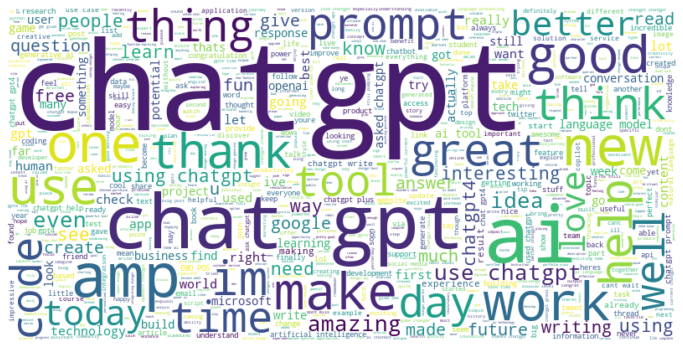

In [41]:
plot_wordcloud(df_positive, "processed_tweet_without_stopwords")

### 5.3 Neutral Tweets' WordCloud <a class="anchor" id="5.3_neutral_tweets'"></a>


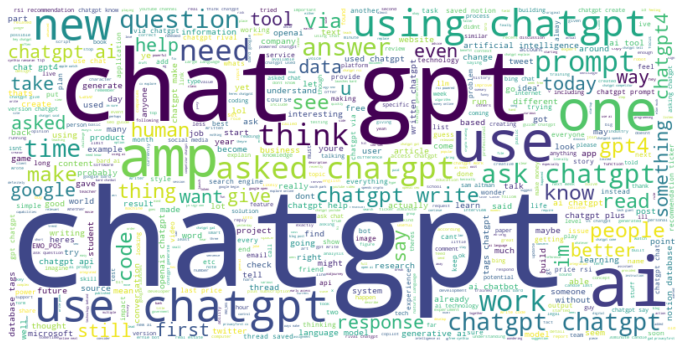

In [42]:
plot_wordcloud(df_neutral, "processed_tweet_without_stopwords")

### 5.4 Negative Tweets' WordCloud <a class="anchor" id="5.4_negative_tweets'"></a>


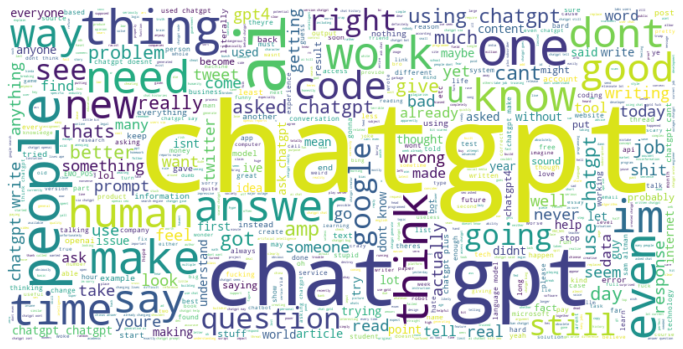

In [43]:
plot_wordcloud(df_negative, "processed_tweet_without_stopwords")

## 6. Conclusion

Based solely on the information provided in the analysis, it is difficult to make a definitive statement about the overall sentiment towards ChatGPT. However, based on broader trends and attitudes towards natural language processing and AI technology, it is possible that many people may be interested in and excited about the capabilities and potential applications of ChatGPT. On the other hand, there may also be concerns or skepticism about the potential consequences of AI technology and its impact on society. Overall, it is likely that there is a mix of both positive and negative attitudes towards ChatGPT, and further research and analysis would be necessary to make more specific conclusions.